## Imports

In [2]:
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True

## Generating data from a linear function

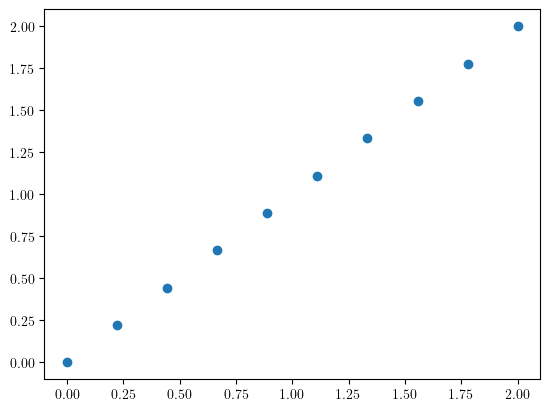

In [3]:
coef = 1
bias = 0
x = np.linspace(0, 2, 10)
data = coef * x + bias

plt.scatter(x, data)
plt.show()

## Generating functions that fit the data in the input space

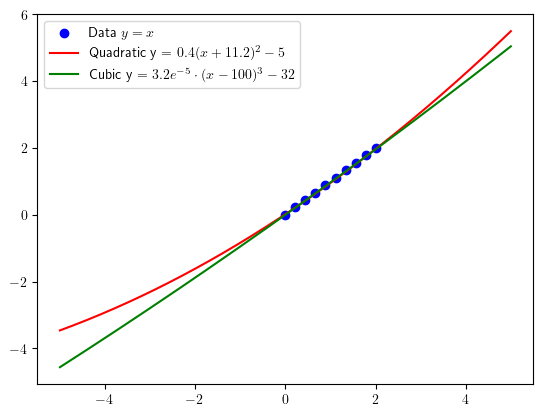

In [4]:
full_x = np.linspace(-5, 5, 1000)

## Quadratic Equation
quad_y = .04 * (full_x + 11.2) ** 2 - 5

## Cubic Equation
r = -100
sq = 0.000032
off = -32
cubic_y = sq*(full_x - r)**3 + off

plt.scatter(x, data, label='Data $y = x$', color='blue')

plt.plot(full_x, quad_y, label='Quadratic y = $0.4(x + 11.2)^2 - 5$', color='red')
plt.plot(full_x, cubic_y, label=f'Cubic y = $3.2e^{{-5}} \\cdot (x {r})^3 - {-off}$', color='green')
plt.legend()
plt.show()